- Date Avg Sale Price 예측하는 Regression Model 수립하기
1. 시계열(Order Date)를 반영해서 시계열 분석하기: 선행 프로젝트와의 차별점
2. Sneaker Name 별로 각각 모델을 수립해야 하나? or Sneaker Name도 독립 변수로 포함을 시켜야 하나

- 주의 사항
1. "Days After Release" 변수에는 음수도 있음: 정식 출시 전에 샘플 신발로 거래를 한 것으로 추정됨

- To Do
1. ARIMA 이용 시계열 분석
2. 시계열 분석 Baseline 짜기 (가능하면 PyTorch 이용해서)

---

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 불러오기
df_og = pd.read_csv('/content/drive/MyDrive/PersonalProject/sneakers/stockx_data_4_regression.csv', encoding = 'utf-8-sig')
df_og.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

In [ ]:
# 분석용 데이터 복사
df = df_og.copy()
df.sample(3)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release
71746,2017-11-24,Off-White,Nike Blazer Mid Off White,580.0,130,2017-09-09,245,Texas,515.235294,76 days
41625,2019-01-24,Yeezy,Adidas Yeezy Boost 350 V2 Sesame,276.0,220,2018-11-23,290,Louisiana,268.400000,62 days
24470,2018-07-26,Yeezy,Adidas Yeezy Boost 350 V2 Cream White,428.0,220,2017-04-29,230,Washington,407.000000,453 days


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99592 entries, 0 to 99591
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order Date           99592 non-null  object 
 1   Brand                99592 non-null  object 
 2   Sneaker Name         99592 non-null  object 
 3   Sale Price           99592 non-null  float64
 4   Retail Price         99592 non-null  int64  
 5   Release Date         99592 non-null  object 
 6   Shoe Size            99592 non-null  int64  
 7   Buyer Region         99592 non-null  object 
 8   Date Avg Sale Price  99592 non-null  float64
 9   Days After Release   99592 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 7.6+ MB


# 데이터 전처리

In [ ]:
# Sale Price 변수 dtype을 int로 바꾸기
df['Sale Price'] = df['Sale Price'].astype('int')

# Days After Release 변수값에서 ' days' 지우고 int로 바꾸기
df['Days After Release'] = df['Days After Release'].apply(lambda x: x.replace(' days',''))
df['Days After Release'] = df['Days After Release'].astype('int')

# Date Avg Sale Price 소수점 첫번째 자리에서 반올림해서 정수로 값 변환하기
df['Date Avg Sale Price'] = df['Date Avg Sale Price'].apply(lambda x: round(x))

df.sample(3)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release
20094,2019-01-12,Yeezy,Adidas Yeezy Boost 350 V2 Blue Tint,420,220,2017-12-16,250,New York,418,392
94866,2019-01-18,Yeezy,adidas Yeezy Boost 350 V2 Static,268,220,2018-12-27,220,California,278,22
49482,2018-12-03,Yeezy,Adidas Yeezy Boost 350 V2 Zebra,285,220,2017-02-25,270,Texas,295,646


In [ ]:
# Sneaker Name별로 Order Date 기준으로 Drop duplicates하는데 Order Date 첫 번째만 남기기 => 데이터 프레임 다시 하나로 합치기

sneaker_names = df['Sneaker Name'].unique().tolist()
df_list = []

for name in sneaker_names:
  temp_df = df[df['Sneaker Name'] == name]
  temp_df.drop_duplicates(subset = 'Order Date', keep = 'first', inplace = True)
  df_list.append(temp_df)

df2 = pd.concat(df_list, axis = 0)
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release
0,2017-09-09,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1100,200,2016-02-19,275,Virginia,1100,568
1,2017-09-10,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,999,200,2016-02-19,300,Kentucky,999,569
2,2017-09-12,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1000,200,2016-02-19,280,Florida,1000,571
3,2017-09-14,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,985,200,2016-02-19,275,Ohio,985,573
4,2017-09-25,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1455,200,2016-02-19,240,Florida,1455,584
...,...,...,...,...,...,...,...,...,...,...
99477,2019-02-09,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,550,220,2018-12-26,265,Kansas,539,45
99507,2019-02-10,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,559,220,2018-12-26,255,New York,536,46
99530,2019-02-11,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,595,220,2018-12-26,230,New York,550,47
99555,2019-02-12,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,461,220,2018-12-26,300,Oregon,556,48


In [ ]:
# df2에서 다시 Sneaker Name 별로 (n-1) 행과 n 행의 Order Date 차이가 1인 데이터만 추출
# -> 이렇게 추출하면, 만약에 Yeezy boost 350 Pirate Black에서 Order Date가 12-11,12-12, 12-24,12-25 이렇게 중간에 끊어진 형태로 추출될 수도 있음
# => 정확하게는, Sneaker Name 별로 Order Date 'A'부터 'B'까지가 1일씩 차이나는 경우만 추출

# Str 형식으로 변경되었던 Order Date 변수를 다시 datetime 타입으로 변환
from datetime import datetime
df2['Order Date'] = df2['Order Date'].apply(lambda x: datetime.fromisoformat(x))

df2['Previous Order Date'] = df2['Order Date'].shift(1)
df2.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release,Previous Order Date
0,2017-09-09,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1100,200,2016-02-19,275,Virginia,1100,568,NaT
1,2017-09-10,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,999,200,2016-02-19,300,Kentucky,999,569,2017-09-09
2,2017-09-12,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1000,200,2016-02-19,280,Florida,1000,571,2017-09-10
3,2017-09-14,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,985,200,2016-02-19,275,Ohio,985,573,2017-09-12
4,2017-09-25,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1455,200,2016-02-19,240,Florida,1455,584,2017-09-14


In [ ]:
# 데이터프레임에서 Sneaker Name 별로 연속된 Dates인 그룹 찾아서 표기 후 다시 한 데이터프레임으로 합치기
# Sneaker Name 별로 groups 값이 1부터 시작함 
df_list = []

for name in sneaker_names:
  temp_df = df2[df2['Sneaker Name'] == name]

  dt = temp_df['Order Date']
  day = pd.Timedelta('1d')
  in_block = ((dt - dt.shift(-1)).abs() == day) | (dt.diff() == day)

  filt = temp_df.loc[in_block]
  breaks = filt['Order Date'].diff() != day
  groups = breaks.cumsum()

  temp_df['groups'] = groups

  df_list.append(temp_df)

df2 = pd.concat(df_list, axis = 0)
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release,Previous Order Date,groups
0,2017-09-09,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1100,200,2016-02-19,275,Virginia,1100,568,NaT,1.0
1,2017-09-10,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,999,200,2016-02-19,300,Kentucky,999,569,2017-09-09,1.0
2,2017-09-12,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1000,200,2016-02-19,280,Florida,1000,571,2017-09-10,NaN
3,2017-09-14,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,985,200,2016-02-19,275,Ohio,985,573,2017-09-12,NaN
4,2017-09-25,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1455,200,2016-02-19,240,Florida,1455,584,2017-09-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99477,2019-02-09,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,550,220,2018-12-26,265,Kansas,539,45,2019-02-08,1.0
99507,2019-02-10,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,559,220,2018-12-26,255,New York,536,46,2019-02-09,1.0
99530,2019-02-11,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,595,220,2018-12-26,230,New York,550,47,2019-02-10,1.0
99555,2019-02-12,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,461,220,2018-12-26,300,Oregon,556,48,2019-02-11,1.0


In [ ]:
# df2.groupby(df2['Sneaker Name']).agg({'groups':[max, len]})
temp = df2.groupby(['Sneaker Name','groups']).agg({'groups':[max, len]})['groups']

# Sneaker Name 별로 각 group의 개수가 50개 이상인 group 확인
temp2 = temp[temp['len'] >= 50]

- 위 코드까지 분석 결과
1. StockX 데이터는 Sneaker Name 별로 Order Date 기준 일정한 간격으로 수집된 연속된 데이터의 개수가 많지 않아서 시계열 분석을 통한 Sale Price Regression에는 어려움이 존재하는 것으로 판단됨.
2. 원래는 ARIMA 분석을 통해 계절성, 추세성 등을 파악하려고 했으나 쉽지 않아 보임
3. Sneaker Name 별로 groups 별로 데이터 개수를 확인해보고 20개 이상 정도인 거는 추출해서 시계열 분석을 통한 Sale Price Regression을 해볼까,,,?
=>  **For autoregressive integrated moving average (ARIMA) models, the rule of thumb is that you should have at least 50 but preferably more than 100 observations (Box and Tiao 1975).**
=> Sneaker Name 별로 Order Date가 연속으로 존재하는 데이터 개수가 50개 이상인 경우 추출해보기

In [ ]:
temp3 = temp2.reset_index().set_index('Sneaker Name') # 멀티 인덱스 풀고 "Sneaker Name"으로 Index 설정하기

# Get the row(s) which have the max value in groups using groupby
idx = temp3.groupby(['Sneaker Name'])['len'].transform(max) == temp3['len'] 
temp4 = temp3[idx][['groups','len']]
# 이제 위 데이터프레임 결과에 따라서 각 Sneaker Name 별로 group에 해당하는 데이터(row) 추출하면 됨

In [ ]:
group_dict = {}
for i in range(len(temp4)):
  group_dict[temp4.iloc[i].name] = temp4.iloc[i].groups

print(group_dict)

{'Adidas Yeezy Boost 350 V2 Beluga 2pt0': 1.0, 'Adidas Yeezy Boost 350 V2 Blue Tint': 1.0, 'Adidas Yeezy Boost 350 V2 Core Black Red 2017': 4.0, 'Adidas Yeezy Boost 350 V2 Cream White': 1.0, 'Adidas Yeezy Boost 350 V2 Semi Frozen Yellow': 2.0, 'Adidas Yeezy Boost 350 V2 Sesame': 2.0, 'Adidas Yeezy Boost 350 V2 Zebra': 1.0, 'Air Jordan 1 Retro High Off White Chicago': 5.0, 'Air Jordan 1 Retro High Off White University Blue': 1.0, 'Nike Air Force 1 Low Off White': 5.0, 'Nike Air Force 1 Low Off White Black White': 2.0, 'Nike Air Force 1 Low Off White Volt': 1.0, 'Nike Air Max 90 Off White': 8.0, 'Nike Air Max 97 Off White': 2.0, 'Nike Air Presto Off White': 9.0, 'Nike Air Presto Off White Black 2018': 4.0, 'Nike Air Presto Off White White 2018': 4.0, 'Nike Air VaporMax Off White 2018': 7.0, 'Nike Air VaporMax Off White Black': 3.0, 'Nike Blazer Mid Off White': 7.0, 'Nike Blazer Mid Off White All Hallows Eve': 1.0, 'Nike Blazer Mid Off White Grim Reaper': 1.0, 'Nike React Hyperdunk 2017 F

In [ ]:
names = list(group_dict.keys())
group_dict[names[1]]

1.0

In [ ]:
# df2에서 group_dict에서의 key값 별로 value 값에 해당하는 데이터만 추출하기
names = list(group_dict.keys())

df_list = []

for name in names:
  temp_df = df2[(df2['Sneaker Name'] == name) &(df2['groups'] == group_dict[name])]
  df_list.append(temp_df)

ts_df = pd.concat(df_list, axis = 0)  # Time Series(시계열) 분석용 데이터

In [ ]:
del df2, temp, temp2, temp3, temp4, temp_df

In [ ]:
ts_df = ts_df.reset_index(drop = True).drop(columns = ['groups'])

In [ ]:
ts_df # Date Avg Sale Price가 Target 값!!

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release,Previous Order Date
0,2017-11-16,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,600,220,2017-11-25,310,Michigan,633,-9,2019-02-13
1,2017-11-17,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,605,220,2017-11-25,290,Tennessee,618,-8,2017-11-16
2,2017-11-18,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,679,220,2017-11-25,250,New Jersey,633,-7,2017-11-17
3,2017-11-19,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,600,220,2017-11-25,270,Washington,594,-6,2017-11-18
4,2017-11-20,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,598,220,2017-11-25,290,California,566,-5,2017-11-19
...,...,...,...,...,...,...,...,...,...,...,...
5111,2019-02-09,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,550,220,2018-12-26,265,Kansas,539,45,2019-02-08
5112,2019-02-10,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,559,220,2018-12-26,255,New York,536,46,2019-02-09
5113,2019-02-11,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,595,220,2018-12-26,230,New York,550,47,2019-02-10
5114,2019-02-12,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,461,220,2018-12-26,300,Oregon,556,48,2019-02-11


# ARIMA 이용 시계열 분석
- 참고 링크
1. https://byeongkijeong.github.io/ARIMA-with-Python/
2. https://kimginam1995.tistory.com/557

In [ ]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116 entries, 0 to 5115
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Order Date           5116 non-null   datetime64[ns]
 1   Brand                5116 non-null   object        
 2   Sneaker Name         5116 non-null   object        
 3   Sale Price           5116 non-null   int64         
 4   Retail Price         5116 non-null   int64         
 5   Release Date         5116 non-null   object        
 6   Shoe Size            5116 non-null   int64         
 7   Buyer Region         5116 non-null   object        
 8   Date Avg Sale Price  5116 non-null   int64         
 9   Days After Release   5116 non-null   int64         
 10  Previous Order Date  5116 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 439.8+ KB


In [ ]:
ts_df.head(3)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release,Previous Order Date
0,2017-11-16,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,600,220,2017-11-25,310,Michigan,633,-9,2019-02-13
1,2017-11-17,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,605,220,2017-11-25,290,Tennessee,618,-8,2017-11-16
2,2017-11-18,Yeezy,Adidas Yeezy Boost 350 V2 Beluga 2pt0,679,220,2017-11-25,250,New Jersey,633,-7,2017-11-17


- 고민
1. ARIMA 모델을 이용하기 전에 ts_df를 Sneaker Name에 따라서 여러 데이터 프레임으로 나눠서 사용할까? 아니면 그 때 그 때 for문에서 돌면서 불러와서 사용할까?

In [ ]:
temp_df = ts_df[ts_df['Sneaker Name'] == names[0]][['Order Date','Date Avg Sale Price']]
temp_df.set_index('Order Date', inplace = True)

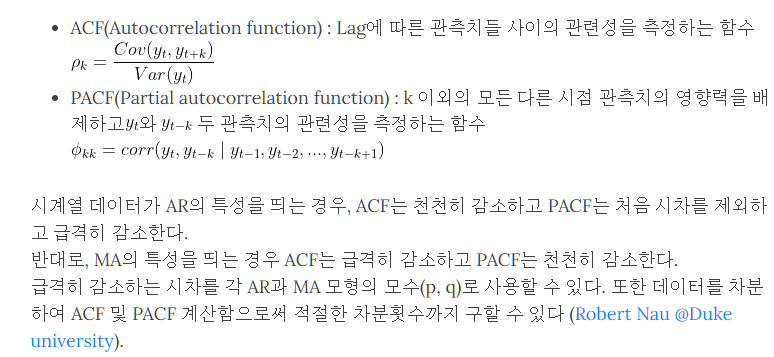

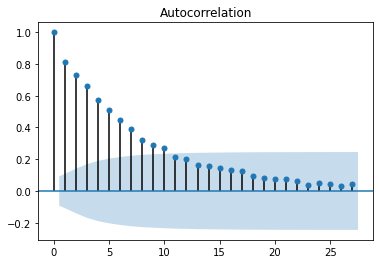

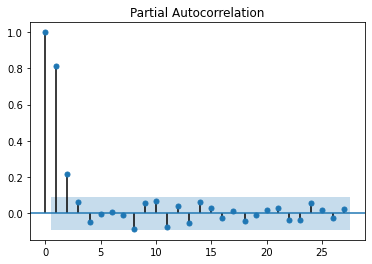

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(temp_df)
plot_pacf(temp_df)
plt.show()

In [ ]:
ts_df.to_csv('stockx_final.csv', encoding = 'utf-8-sig')